In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

from satforecast.data import data
from satforecast.modeling.data_selection import rolling_batch
from satforecast.modeling.data_selection import mean_and_std_of_files
from satforecast.modeling.train import train
from satforecast.modeling.model_selection import GridSearchNCV
from satforecast.data.viz import get_border_map

data.download()
image_dir = data.process_gs_rainfall_daily(scale=0.1)
image_files = data.get_files(image_dir, '*.npy')

In [2]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std
    
    def __repr__(self):
        return f'Normalization(mean={self.mean}, std={self.std})'

    def forward(self, x):
        return (x - self.mean) / self.std

class RevNormalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std
    
    def __repr__(self):
        return f'RevNormalization(mean={self.mean}, std={self.std})'

    def forward(self, z):
        return z * self.std + self.mean

class CRNN(nn.Module):
    def __init__(
            self,
            in_channels,
            hidden_channels,
            kernal_size_,
            padding_,
            train_files = None,
            do_rev_norm = False
    ):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.do_norm = True if train_files is not None else False
        self.do_rev_norm = do_rev_norm
        if self.do_norm:
            mean, std = mean_and_std_of_files(train_files)
            self.norm = Normalization(mean, std)

        self.conv1 = nn.Conv2d(in_channels + hidden_channels, hidden_channels, kernel_size=kernal_size_, padding=padding_)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernal_size_, padding=padding_)
        self.conv3 = nn.Conv2d(hidden_channels, in_channels, kernel_size=kernal_size_, padding=padding_)
        
        if self.do_rev_norm:
            self.rev_norm = RevNormalization(mean, std)

    def forward(self, x, h):
        if self.do_norm:
            x = self.norm(x)
        h = torch.cat((x, h), dim=1)
        h = torch.tanh(self.conv1(h))
        h = torch.tanh(self.conv2(h))
        x = self.conv3(h)
        if self.do_rev_norm:
            x = self.rev_norm(x)
        return x, h

    def init_hidden(self, batch_size, image_size):
        return torch.zeros(batch_size, self.hidden_channels, *image_size)

    def predict(self, X):
        seq_len = X.shape[1]
        
        hidden = self.init_hidden(X.shape[0], X.shape[-2:])

        for step in range(seq_len - 1):
            _, hidden = self.forward(X[:,step], hidden)

        pred, _ = self.forward(X[:, -1], hidden)
        return pred

## Semi-full training

In [3]:
%%time

# Data constants
DEV_N_IMAGES = 2_000
TRAIN_FRAC = 0.95
VAL_FRAC = 0.05
SEQ_LEN = 5
dev_image_files = image_files[:DEV_N_IMAGES]

# Training constants
BATCH_SIZE = 64
MAX_EPOCHS = 50
MIN_IMPROV = 0.01
MAX_ITER_IMPROV = 3

params = {
    'model__in_channels': [1],
    'model__hidden_channels': [2],
    'model__kernal_size_': [3],
    'model__padding_': [1],
    'model__do_norm': [True, False],
    'model__do_rev_norm': [True, False],
    'optimizer': [torch.optim.Adam, torch.optim.AdamW],
    'scheduler': [None, torch.optim.lr_scheduler.StepLR],
    'scheduler__step_size': [2],
    'train__train_frac': [TRAIN_FRAC],
    'train__val_frac': [VAL_FRAC],
    'train__seq_len': [SEQ_LEN],
    'train__batch_size': [BATCH_SIZE],
    'train__max_epochs': [MAX_EPOCHS],
    #'train__val_level': ['batch', 'epoch'],
    'train__early_stopping': [True],
    'train__min_improv': [MIN_IMPROV],
    'train__max_iter_improv': [MAX_ITER_IMPROV],
    #'train__scheduler_level': ['batch', 'epoch'],
    'train__shuffle': [True, False],
    'train__log_level': [1],
}

grid = GridSearchNCV(
    model_class = CRNN,
    name_base = 'crnn_v0',
    files_list = dev_image_files,
    param_grid = params,
    criterion = nn.MSELoss,
    nests_per_config = 2,
    log_level = 3
)
grid.fit()

Performing NCV on 32 configurations
Working on config_0
{'criterion': "<class 'torch.nn.modules.loss.MSELoss'>",
 'criterion_params': {},
 'files_n': 2000,
 'model_params': {'do_norm': True,
                  'do_rev_norm': True,
                  'hidden_channels': 2,
                  'in_channels': 1,
                  'kernal_size_': 3,
                  'padding_': 1},
 'optimizer': "<class 'torch.optim.adam.Adam'>",
 'optimizer_params': {},
 'scheduler': 'None',
 'scheduler_params': {'step_size': 2},
 'train_params': {'batch_size': 64,
                  'early_stopping': True,
                  'log_level': 1,
                  'max_epochs': 50,
                  'max_iter_improv': 3,
                  'min_improv': 0.01,
                  'seq_len': 5,
                  'shuffle': True,
                  'train_frac': 0.95,
                  'val_frac': 0.05}}
nest 1
Epoch 0: Validation loss = 0.03464021533727646, Epoch time = 5.9, Validation time = 0.2
Epoch 1: Validation loss 

KeyboardInterrupt: 

In [ ]:
# Plot losses for all configs

CRNN(
  (norm): Normalization(mean=0.20870788399684306, std=0.2143017419207392)
  (conv1): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rev_norm): RevNormalization(mean=0.20870788399684306, std=0.2143017419207392)
)
Batch 0: Validation loss = 0.04578673094511032, Train time = 0.0, Update time = 0.0, Validation time = 0.0
Batch 1: Validation loss = 0.04544944316148758, Train time = 0.0, Update time = 0.0, Validation time = 0.0

!!! Early stopping triggered after 0 epochs and 2 batches !!!



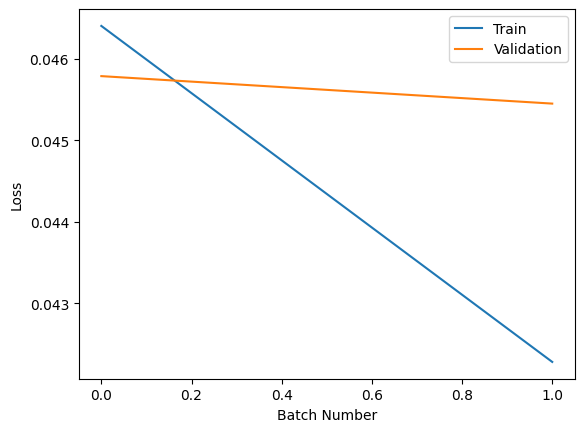

In [5]:
# Test run
TEST_N_IMAGES = 100
test_image_files = image_files[:TEST_N_IMAGES]
test_crnn = CRNN(
    in_channels=1,
    hidden_channels=2,
    kernal_size_=3,
    padding_=1,
    train_files=test_image_files[:int(0.6*TEST_N_IMAGES)],
    do_rev_norm = True
)

print(test_crnn)

_, train_loss, val_loss = train(
    model = test_crnn,
    model_name = 'test_crnn_v0',
    criterion = nn.MSELoss(),
    optimizer = torch.optim.Adam(test_crnn.parameters()),
    files_list = test_image_files,
    train_frac = 0.6,
    val_frac = 0.1,
    seq_len = 5,
    batch_size = 5,
    max_epochs = 3,
    val_level = 'batch',
    early_stopping = True,
    min_improv = 0.003,
    max_iter_improv = 1,
    shuffle = True,
    log_level = 1,
    save_model = False
)

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');

Batch 0: Validation loss = 0.13257259130477905, Train time = 0.1, Update time = 0.4, Validation time = 0.3
Batch 1: Validation loss = 0.12960001826286316, Train time = 0.2, Update time = 0.3, Validation time = 0.3
Batch 2: Validation loss = 0.12672758102416992, Train time = 0.1, Update time = 0.3, Validation time = 0.2
Batch 3: Validation loss = 0.12396068125963211, Train time = 0.1, Update time = 0.3, Validation time = 0.2
Batch 4: Validation loss = 0.12132122367620468, Train time = 0.2, Update time = 0.4, Validation time = 0.2
Batch 5: Validation loss = 0.11878114193677902, Train time = 0.1, Update time = 0.3, Validation time = 0.2
Batch 6: Validation loss = 0.11632722616195679, Train time = 0.1, Update time = 0.3, Validation time = 0.3
Batch 7: Validation loss = 0.11393710225820541, Train time = 0.2, Update time = 0.3, Validation time = 0.2
Batch 8: Validation loss = 0.11163531243801117, Train time = 0.1, Update time = 0.3, Validation time = 0.2
Batch 9: Validation loss = 0.10936370

Batch 23: Validation loss = 0.035608116537332535, Train time = 0.1, Update time = 0.3, Validation time = 0.2
Batch 24: Validation loss = 0.035562433302402496, Train time = 0.1, Update time = 0.3, Validation time = 0.2
Batch 25: Validation loss = 0.03551092743873596, Train time = 0.1, Update time = 0.3, Validation time = 0.2
Batch 26: Validation loss = 0.03545769676566124, Train time = 0.1, Update time = 0.3, Validation time = 0.2
Batch 0: Validation loss = 0.03541533276438713, Train time = 0.1, Update time = 0.3, Validation time = 0.2
Batch 1: Validation loss = 0.0353701189160347, Train time = 0.1, Update time = 0.3, Validation time = 0.2
Batch 2: Validation loss = 0.03532423451542854, Train time = 0.1, Update time = 0.3, Validation time = 0.2
Batch 3: Validation loss = 0.035282690078020096, Train time = 0.1, Update time = 0.3, Validation time = 0.2
Batch 4: Validation loss = 0.03524421900510788, Train time = 0.1, Update time = 0.3, Validation time = 0.2
Batch 5: Validation loss = 0.03

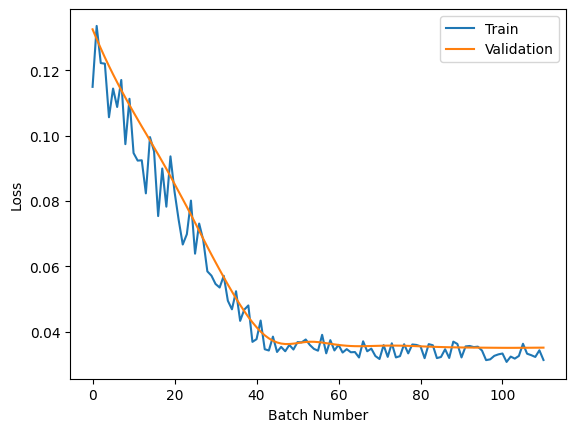

In [11]:
# Data constants
DEV_N_IMAGES = 2_000
TRAIN_FRAC = 0.95
VAL_FRAC = 0.05
SEQ_LEN = 5

# Model
dev_image_files = image_files[:DEV_N_IMAGES]
dev_crnn = CRNN(
    in_channels=1,
    hidden_channels=2,
    kernal_size_=3,
    padding_=1,
    train_files=dev_image_files[:int(TRAIN_FRAC * DEV_N_IMAGES)]
)
model_name = 'dev_crnn_v0'
crit = nn.MSELoss()
optim = torch.optim.Adam(dev_crnn.parameters())

# Training constants
BATCH_SIZE = 64
MAX_EPOCHS = 50
MIN_IMPROV = 0.001
MAX_ITER_IMPROV = 50

train_loss, val_loss = train(
    model = dev_crnn,
    model_name = model_name,
    criterion = crit,
    optimizer = optim,
    files_list = dev_image_files,
    train_frac = TRAIN_FRAC,
    val_frac = VAL_FRAC,
    seq_len = SEQ_LEN,
    batch_size = BATCH_SIZE,
    max_epochs = MAX_EPOCHS,
    val_level = 'batch',
    early_stopping = True,
    min_improv = MIN_IMPROV,
    max_iter_improv = MAX_ITER_IMPROV,
    shuffle = True,
    log_level = 1,
    save_model = True
)

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');

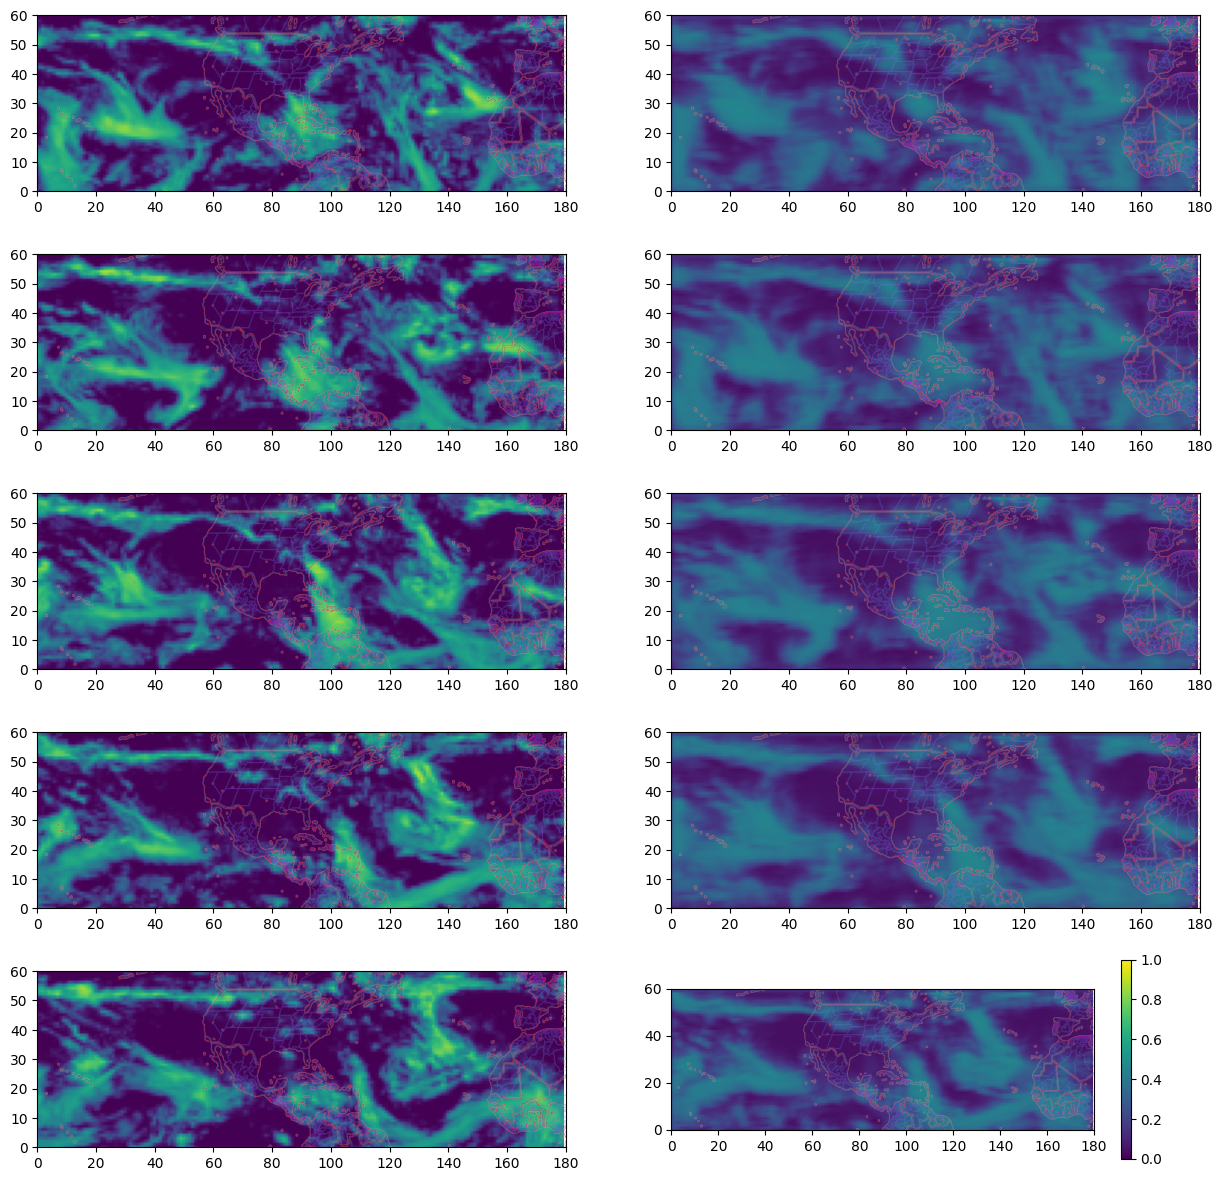

In [12]:
N_DAYS = 5
COLS = 2
IMAGE_SIZE = (60, 180)

bmap = plt.imread(get_border_map())

fig, axs = plt.subplots(N_DAYS, COLS, figsize=(15, 3*N_DAYS))

dev_crnn.eval()

for i in range(N_DAYS):

    # Get predicted
    X, y = rolling_batch(image_files[DEV_N_IMAGES + i: DEV_N_IMAGES + i + SEQ_LEN + 1], start=0, stop=SEQ_LEN + 1, seq_len=SEQ_LEN)
    y = torch.reshape(y, IMAGE_SIZE).numpy()
    y_pred = torch.reshape(dev_crnn.predict(X), IMAGE_SIZE).detach().numpy()

    # Plot real
    y_shape = y.shape
    plt.subplot(N_DAYS, COLS, i * COLS + 1)
    plt.imshow(y, vmin=0, vmax=1)
    plt.imshow(bmap, extent=[0, y_shape[1], 0, y_shape[0]])

    # Plot predicted
    plt.subplot(N_DAYS, COLS, i * COLS + 2)
    plt.imshow(y_pred, vmin=0, vmax=1)
    plt.imshow(bmap, extent=[0, y_shape[1], 0, y_shape[0]])

plt.colorbar();